# Full control with the ask-and-tell interface

For day-to-day use, we recommend sampling or optimising via one of the "controller" classes, for example the  [`OptimisationController`](http://pints.readthedocs.io/en/latest/optimisers/running.html) or the [`MCMCController`](https://pints.readthedocs.io/en/latest/mcmc_samplers/running.html) class.

Internally, these classes create an optimiser or sampler, configure it for use, and then run the procedure, logging important information along the way.

However, there are cases where you might want more control than the controller interface offers, and in those situations we recommend using the chosen method directly, via its "ask-and-tell" interface.

Examples of such scenarios include:

- debugging: if a method doesn't do what you think it should do, it can be useful to dig in
- visualisation: using the ask-and-tell interface lets you extract more information to (interactively) visualise what a method is doing
- hierarchical sampling: hierarchical schemes can be set up that use one or several sampling methods internally

## Example: visualising an optimisation with xNES

Below, we show an example of using the ask-and-tell interface to visually inspect an optimisation routine.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

# Choose an initial position
x0 = [0, 700]

Next, we create an xNES optimiser object and run a simple optimisation:

Now we can run a simple optimisation:

In [2]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
for i in range(500):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores for each point
    fxs = [score(x) for x in xs]
    # Pass the result back to XNES
    xnes.tell(fxs)

# Show the best solution
print(xnes.x_best())

[1.50049131e-02 5.00184073e+02]


One advantage of this type of interface is that it gives us the freedom to evaluate the score function in any way we like. For example using parallelisation:

In [3]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Create parallel evaluator
e = pints.ParallelEvaluator(score)

# Run optimisation
for i in range(500):
    # Get the next points to evaluate
    xs = xnes.ask()
    # Evaluate the scores in parallel!
    fxs = e.evaluate(xs)
    # Pass the result back to XNES
    xnes.tell(fxs)

# Show the best solution
print(xnes.x_best())

[1.50049131e-02 5.00184073e+02]


Note that, for our toy problem, the time it takes to set up parallelisation actually outweighs its benefits!

### Tracking the error over time

We now modify the code to track how the lowest error known to the optimiser changes over time:

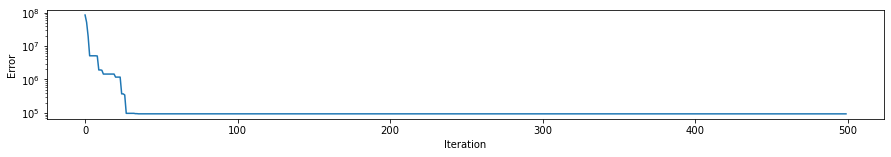

In [4]:
# Create an XNES object
xnes = pints.XNES(x0, boundaries=boundaries)

# Run optimisation
f_best = []
for i in range(500):
    # Get points to evaluate, evaluate them, tell XNES
    xs = xnes.ask()
    fxs = [score(x) for x in xs]
    xnes.tell(fxs)
    
    # Store the best score
    f_best.append(xnes.f_best())

# Show how the score converges
plt.figure(figsize=(15, 2))
plt.semilogy()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.plot(f_best)
plt.show()

Similarly, we can track the point with the lowest known error.
And because this is a 2d example we can plot it too:

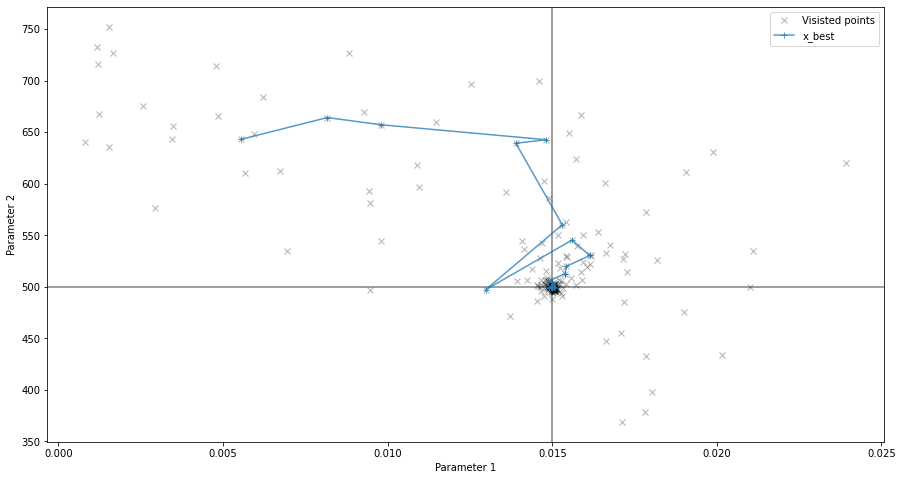

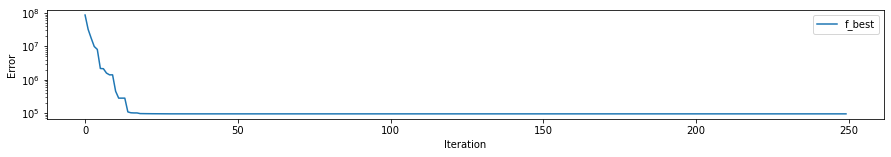

In [5]:
# Create an XNES object
xnes = pints.XNES(x0, sigma0=[0.005, 50], boundaries=boundaries)

# Run optimisation
x_visited = []
x_best = []
f_best = []
for i in range(250):
    # Get the next points, evaluate their scores, and tell xNES
    xs = xnes.ask()
    fxs = [score(x) for x in xs]
    xnes.tell(fxs)

    # Store the requested points
    x_visited.extend(xs)
    
    # Store the best position and score seen so far
    x_best.append(xnes.x_best())
    f_best.append(xnes.f_best())

x_visited = np.array(x_visited)
x_best = np.array(x_best)

# Plot the optimiser trajectory
plt.figure(figsize=(15, 8))
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.axhline(real_parameters[1], color='k', alpha=0.5)
plt.axvline(real_parameters[0], color='k', alpha=0.5)
plt.plot(x_visited[:, 0], x_visited[:, 1], 'x', color='k', alpha=0.3, label='Visisted points')
plt.plot(x_best[:, 0], x_best[:, 1], '+-', alpha=0.75, label='x_best')
plt.legend()

# Plot the optimiser score
plt.figure(figsize=(15, 2))
plt.semilogy()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.plot(f_best, label='f_best')
plt.legend()
plt.show()

### Best point versus guessed point

This is where things get a little bit complicated:
Methods like CMA-ES, xNES, and SNES all work by sampling points from a proposal distribution, and then updating this distribution based on the points' evaluations.
The mean of this distribution represents a best guess of where the optimum is.

This means that we have two "best" points at each iteration: the best point (lowest error or highest log-likelihood) that we have actually visited, and the mean of the proposal distribution.
As the optimiser converges to the optimum, we expect these two points to become the same.
But note that this is not guaranteed to happen.

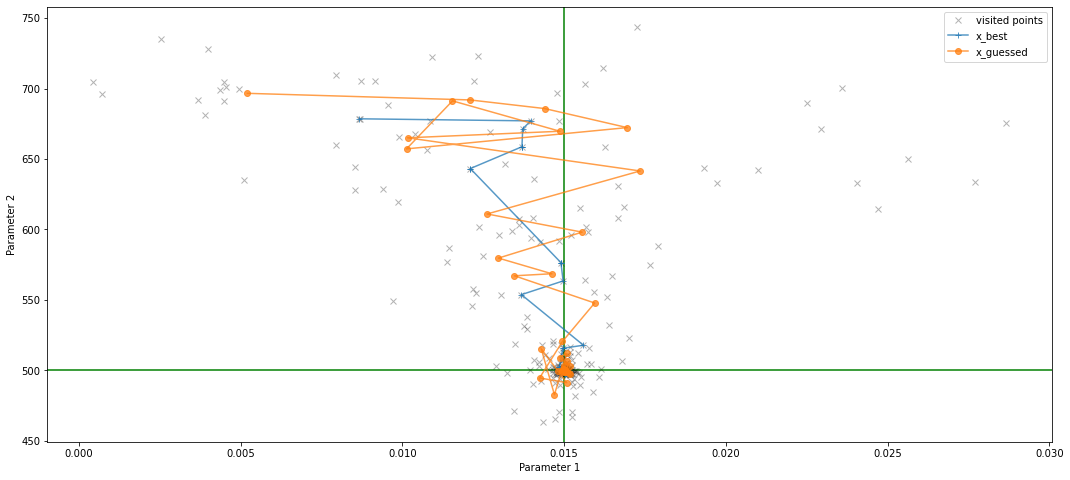

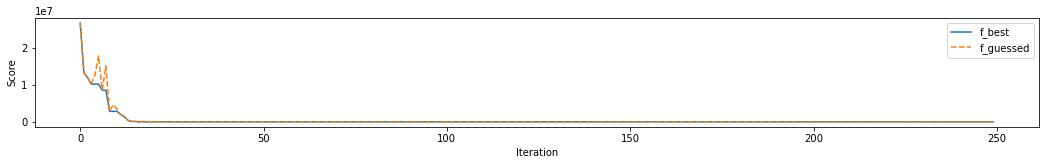

In [6]:
# Create an XNES object
xnes = pints.XNES(x0, sigma0=[0.01, 10], boundaries=boundaries)

# Run optimisation
x_visited = []
x_guessed = []
f_guessed = []
x_best = []
f_best = []
for i in range(250):
    # Get the next points, evaluate their scores, and tell xNES
    xs = xnes.ask()
    fxs = [score(x) for x in xs]
    xnes.tell(fxs)

    # Store the requested points
    x_visited.extend(xs)
    
    # Store the current guess
    x_guessed.append(np.mean(xs, axis=0))

    # Store the accompanying score
    f_guessed.append(xnes.f_guessed())
    
    # Store the best position and score seen so far
    x_best.append(xnes.x_best())
    f_best.append(xnes.f_best())

x_visited = np.array(x_visited)
x_guessed = np.array(x_guessed)
x_best = np.array(x_best)

# Plot the optimiser trajectory
plt.figure(figsize=(18, 8))
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.axhline(real_parameters[1], color='green')
plt.axvline(real_parameters[0], color='green')
plt.plot(x_visited[:, 0], x_visited[:, 1], 'x', color='k', alpha=0.3, label='visited points')
plt.plot(x_best[:, 0], x_best[:, 1], '+-', alpha=0.75, label='x_best')
plt.plot(x_guessed[:, 0], x_guessed[:, 1], 'o-', alpha=0.75, label='x_guessed')
plt.legend()

# Plot the optimiser score
plt.figure(figsize=(18, 2))
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.plot(f_best, label='f_best')
plt.plot(f_guessed, '--', label='f_guessed')
plt.legend()
plt.show()

In the example above, we can see that the mean of the proposal distribution, `x_guessed`, moves around a lot more than the best seen point, `x_best`.
This is expected, as `x_guessed` is updated at each iteration, while `x_best` only changes if a new best point is found.

Another thing we can notice in the top plot is that `x_best` always overlaps with a visited point, while `x_guessed` doesn't usually overlap with a visited point.
So if we never visit `x_guessed`, how do we determine `f_guessed`?
The answer is that we don't, and `f_guessed` is an approximation (as also indicated in the docstrings for these methods).
The easiest way to approximate `f_guessed` is to simply use the best evaluation seen that iteration, and this is what xNES does.
As the method converges to `x_guessed`, the proposal distribution gets narrower and narrower, so that the accuracy of this estimate increases towards the end of the optimiser run.